# Prediction of Oscar Nominees 
![logo](http://www1.oscars.org/vendor/old/images/logo.png)

## Purpose of this tutorial
This tutorial will introduce you the basic steps of doing preditions, taking Oscar nominees as an example. The tutorial will cover the following couple of knowledge:
- Gathering data resource from Kaggle and using web scrapping
- Data cleaning and data wrangling
    - Joining multiple tables
- Exploratory data analysis
- Feature Training
- Model Training

**Content**

- [Data Collection](#Data-Collection)
- [Load Data](#Load-Data)
- [Data Manipulation](#Data-Manipulation)
    - [Handling Imbalanced Data](#Handling-Imbalanced-Data)
    - [Check The Null Value](#Check-The-Null-Value)
- [Exploratory Data Aalysis](#Exploratory-DataAalysis)
- [Feature Engineering](#Feature-Engineering)
- [Model Training](#Model-Training)
- [Further Reading](#Further-Reading)


## Rules of Oscar Nominations
Before we go deep into our data modeling, we first need to understand how Oscar nomination works. Then, we use these rules to filter the movies that are qualified for our dataset.
Rules relavant to dataset:
1. Feature length (defined as over 40 minutes)
2. A film must have been released in the preceding year, from midnight at the start of January 1 to midnight at the end of December 31, in Los Angeles (California)

## Data Collection
### Data Source:
1. Kaggle - [The Oscars Dataset: Preparing for 2017](https://www.kaggle.com/sebask/the-oscars-dataset-preparing-for-2017/data)
2. Kaggle - [TMDB 5000 Movie Dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata/data)
3. Kaggle - [The Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset/data)
4. Kaggle - [350 000+ movies from themoviedb.org](https://www.kaggle.com/stephanerappeneau/350-000-movies-from-themoviedborg/data)

In this tutorial, we will use the first and second data source.

**Note:**I have uploaded the files to Google drive, please download the data files to the same path with this tutorial.

**Download the csv files:**
- [awards.csv](https://drive.google.com/open?id=1YxiqynLgbpeXsy_dkUTmEgmGTvxHJExA)
- [credits.csv](https://drive.google.com/open?id=1QqK1l8lV-Lpu5gnwDpMzSBhFnFc37I4Q)
- [movies.csv](https://drive.google.com/open?id=1_0otdD3eEM_UFl8kNf0qw8ABcTw7GGsD)


### Scope
This tutorial will on focus on predicting the BEST PICTURE nominees of the Academy Awards. We will use three csv files for analysis.

### Preview

The column metatdata is listed as follows:
- The Oscars Dataset 1927-2017


| | |**awards**             | 
|----------|-------------|-------------|
| year | the year of oscar nomination | String |
| ceremony | the nth Academy Awards | Numeric |
| award | type of award | String |
| winner | 1 indicates nominees instead of winner | Numeric |
| movieName | name of the film | String |
| filmInfo | name of the producers | String |

- Movies Dataset 

| | |**movies**        |
|----------|-------------|-----------------------|
| budget |	budget spent on the movie | numeric |
| genres | json files containing the id and name of genres | json |
| homepage | homepage of the movie | string |
| id	| id | string |
| keywords | keywords | string |
| original_language	| original language | string |
| original_title	| original title | string |
| overview	| description of the movie | string |
| popularity	| popularity | numeric |
| production_companies	| json files including the name and id of the production company | json |
| production_countries	| json files including the iso_3166_1 and name of production country | json |
| release_date	| release_date of the film | datetime |
| revenue	| revenue in USD | numeric |
| runtime	| time span of the movie | time |
| spoken_languages	| json files containing "iso_639_1" (eg.en) and name of the language | json |
| status	| status of the movie ie. Released | string |
| tagline	| tagline | string |
| title	| title of the movie | string |
| vote_average	| average score | numeric |
| vote_count | vote count | numeric |

- Movie Credits Data

| | |**credits** | 
|------------|------------------|--------------------|
| movie_id | movie id | numeric |
| title | movie title | string |
| cast | json files containing the cast of a movie {"cast_id","character", "credit_id", "gender", "order"} | json |
| crew | json files containing the crew of a movie {"credit_id","gender","department","job","name"} | json |

- Main libraries:
    - Requests
    - BeautifulSoup
    - Matplotlib
    - Seaborn
    - Numpy
    - Json
    - Pandas
    - Skitlearn

In [2]:
import io, time, json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sklearn
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

### Web Scraping
Since the oscar dataset from Kaggle doesn't contain data in year 2016 and 2017, we can write a simple scrapper to scrap the data from [The Official Academy Awards Database](http://awardsdatabase.oscars.org/) and append it to the current data set.

**Notice**

- Parse a header ('User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36') to the [requests.get(url, headers = headers)](http://docs.python-requests.org/en/master/user/quickstart/) function, or the results returned will be incomplete.
- If you want to know the alignment of the html framework on Oscar website, you can right click on the Chrome webpage, select "Inspect", then you will enter the Chrome development mode which you can find the position that the information is located.
- The value in "is_winner" will be 1 for all movies since the movies retrieved from Oscar website are all nominees.

In [3]:
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL.

    Args:
        url (string): 

    Returns:
        result: dict, movie name as key, movie information as value
    """
    # remember to use browser header here, or cannot retrieve full data from the website
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    response = requests.get(url, headers = headers)
    html = response.content
    soup = BeautifulSoup(html,'lxml')

    result = {}
    for item in soup.find_all('div', {'class':'result-subgroup subgroup-awardcategory-chron'}):
        try:
            award_title = item.find('div',{'class':'result-subgroup-title'}).find('a',{'class':'nominations-link'}).contents[0]
            if award_title == 'BEST PICTURE':
                sub_groups = item.find_all('div',{'class':'result-details awards-result-actingorsimilar'})
                for sub in sub_groups:
                    sub_result = {}
                    film_title = sub.find('div',{'class':'awards-result-film-title'}).find('a',{'class':'nominations-link'}).contents[0]
#                     is_winner = sub.find('span',{'class':'glyphicon glyphicon-star'})
#                     if is_winner is not None:
#                         is_winner = 1
#                     else:
#                         is_winner = 0
                    is_winner = 1
                    statement = sub.find('div',{'class':'awards-result-nominationstatement'}).find('a',{'class':'nominations-link'}).contents[0]           
                    sub_result['film_title'] = film_title
                    sub_result['is_winner'] = is_winner
                    sub_result['statement'] = statement
                    result[film_title] = sub_result
        except Exception:
            pass
    return result


Retrieve the BEST PICTURE movie data in 2016 and 2017 from the Oscar database.

In [4]:
# data of year 2016
best_2016 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:89,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2017
best_2017 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:90,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')


Have a look at the best_2016 data

In [5]:
best_2016

{'Arrival': {'film_title': 'Arrival',
  'is_winner': 1,
  'statement': 'Shawn Levy, Dan Levine, Aaron Ryder and David Linde, Producers'},
 'Fences': {'film_title': 'Fences',
  'is_winner': 1,
  'statement': 'Scott Rudin, Denzel Washington and Todd Black, Producers'},
 'Hacksaw Ridge': {'film_title': 'Hacksaw Ridge',
  'is_winner': 1,
  'statement': 'Bill Mechanic and David Permut, Producers'},
 'Hell or High Water': {'film_title': 'Hell or High Water',
  'is_winner': 1,
  'statement': 'Carla Hacken and Julie Yorn, Producers'},
 'Hidden Figures': {'film_title': 'Hidden Figures',
  'is_winner': 1,
  'statement': 'Donna Gigliotti, Peter Chernin, Jenno Topping, Pharrell Williams and Theodore Melfi, Producers'},
 'La La Land': {'film_title': 'La La Land',
  'is_winner': 1,
  'statement': 'Fred Berger, Jordan Horowitz and Marc Platt, Producers'},
 'Lion': {'film_title': 'Lion',
  'is_winner': 1,
  'statement': 'Emile Sherman, Iain Canning and Angie Fielder, Producers'},
 'Manchester by the S

## Load Data

### Read From CSV File

In this section, we will read the csv file into pandas dataframe. Pandas is a easy to use library which allows users to read a file in different format such as CSV and Excel into a dataframe (same as the dataframe in R). We then can manipulate the data, common function such as join(), merge(), drop(), fillna(), reset_index(), etc., will be explored in this section.

In [6]:
import numpy as np
import pandas as pd

#### Read data
Read data from **awards.csv**, **credits.csv** and **movies.csv**

In [7]:
# read from awar
df_awards = pd.read_csv('awards.csv', skiprows = 1, names=['year','ceremony','award','winner','movieName','filmInfo'])
df_credits = pd.read_csv('credits.csv')
df_movies = pd.read_csv('movies.csv')

#### View data

In [8]:
print(df_awards.head())

        year  ceremony    award  winner            movieName          filmInfo
0  1927/1928         1    Actor     NaN  Richard Barthelmess         The Noose
1  1927/1928         1    Actor     1.0        Emil Jannings  The Last Command
2  1927/1928         1  Actress     NaN       Louise Dresser   A Ship Comes In
3  1927/1928         1  Actress     1.0         Janet Gaynor        7th Heaven
4  1927/1928         1  Actress     NaN       Gloria Swanson    Sadie Thompson


In [9]:
print(df_credits.head())
# df_credits.loc[0,'crew']

   movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_id": "52fe479ac3a36847f813eaa3",

Print the result of the three dataframes out and have a look at the dataset.


```python
>>> df_awards.head()

    year	ceremony	award	winner	movieName	filmInfo
0	1927/1928	1	Actor	NaN	Richard Barthelmess	The Noose
1	1927/1928	1	Actor	1.0	Emil Jannings	The Last Command
2	1927/1928	1	Actress	NaN	Louise Dresser	A Ship Comes In
3	1927/1928	1	Actress	1.0	Janet Gaynor	7th Heaven
4	1927/1928	1	Actress	NaN	Gloria Swanson	Sadie Thompson

>>> df_credits.head()

    movie_id	title	cast	crew
0	19995	Avatar	[{"cast_id": 242, "character": "Jake Sully", "...	[{"credit_id": "52fe48009251416c750aca23", "de...
1	285	Pirates of the Caribbean: At World's End	[{"cast_id": 4, "character": "Captain Jack Spa...	[{"credit_id": "52fe4232c3a36847f800b579", "de...
2	206647	Spectre	[{"cast_id": 1, "character": "James Bond", "cr...	[{"credit_id": "54805967c3a36829b5002c41", "de...
3	49026	The Dark Knight Rises	[{"cast_id": 2, "character": "Bruce Wayne / Ba...	[{"credit_id": "52fe4781c3a36847f81398c3", "de...
4	49529	John Carter	[{"cast_id": 5, "character": "John Carter", "c...	[{"credit_id": "52fe479ac3a36847f813eaa3", "de...

```

In [10]:
df_movies.head() #keep it
# df_movies['production_countries']

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


#### Append the scrapped data

Append the data we scrapped to the df_awards and pass the column name to the columns parameter when constructing pd.DataFrame Or there will be a runtime error

In [11]:
# append the data we scrapped to the df_awards
data=[]
for k,v in best_2016.items():
    row = []
    row.append(['2016', 89, 'Best Picture', v['is_winner'], v['film_title'], v['statement']])
    data.append(row[0])

    
# pass the column name to the columns!!! Or there will be a runtime error
df_awards=df_awards.append(pd.DataFrame(data,columns=['year','ceremony','award','winner','movieName','filmInfo']),ignore_index=True)

data_=[]
for k,v in best_2017.items():
    row = []
    row.append(['2017', 90, 'Best Picture', v['is_winner'], v['film_title'], v['statement']])
    data.append(row[0])

df_awards=df_awards.append(pd.DataFrame(data,columns=['year','ceremony','award','winner','movieName','filmInfo']),ignore_index=True)



## Data Manipulation
#### Join tables 
Firstly, we join df_credits (from credits.csv) with df_movies (from movies.csv) into df_credits_movies by df_credits.movie_id == df_movies.id
Secondly, we join df_credits_movies with Oscar Best Picture nominees dataframe df_picture_awards

#### I. join df_credits and df_movies
- drop column 'title' in df_credits, since 'title' exists in both dataframe
- construct new joined data frame **df_credits_movies** by using inner join to join df_credits and df_movies by df_credits.movie_id == df_movies.id

In [12]:
if 'title' in df_credits.columns:
    df_credits = df_credits.drop('title',axis=1)
df_credits_movies = df_credits.set_index('movie_id').join(df_movies.set_index('id'))
# df_credits_movies = df_credits.merge(df_movies, left_on = 'movie_id', right_on = 'id', how = 'inner')

In [13]:
df_credits_movies.dtypes

cast                     object
crew                     object
budget                    int64
genres                   object
homepage                 object
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object

- reset the data types in the dataframe
- type of **release_date**: object -> datetime
- get the earliest date of **release_date**

In [14]:
df_credits_movies['release_date'] = pd.to_datetime(df_credits_movies['release_date'])
#get the earliest release date from the dataset
min_year = min(df_credits_movies['release_date']) #1916-09-04
max_year = max(df_credits_movies['release_date']) #2017-02-03

- Select movies that are in **Outstanding Picture** or **Best Picture** awards category -> **df_picture_awards**

In [15]:
#join df_credits_movies and df_awards by movie name (df_credits_movies.title = df_awards.movieName)
#before that, extract BEST PICTRUE from the df_awards
df_picture_awards = df_awards.loc[df_awards['award'].isin(['Outstanding Picture','Best Picture'])]
df_picture_awards.reset_index(drop = True, inplace = True)

In [16]:
df_credits_movies = df_credits_movies.loc[df_credits_movies['status'].isin(['Released'])]

- Replace all the null value in 'winner' column with 1

In [17]:
# df_picture_awards['winner'].isnull().sum()
df_picture_awards['winner'].fillna(1,inplace = True)

#### Join table II. join df_picture_awards with df_credits_movies
We will use the movieName from df_picture_awards (Oscard awards dataframe) to join with the title (title of movie) from the df_credits_movies (movie information dataframe)
- Before joining by movie name, we need to clean the string in movie name by removing puctuation and transforming the string into lowercase.

In [18]:
import re
movieName = [re.sub(r'[^\w\s]','',x) for x in df_picture_awards['movieName'].str.lower().str.strip().values]
title = [re.sub(r'[^\w\s]','',x) for x in df_credits_movies['title'].str.lower().str.strip().values]

In [19]:
#then, change the title in the movie to lower case
df_picture_awards.loc[:,'movie_title'] = movieName #change the string to lower case
df_credits_movies.loc[:,'movie_title']= title

Check the dataframe, we can see the string in movie_title now is valid

In [20]:
# check the dataframe, we can see the string in movie_title now is valid
print(df_picture_awards.head())

        year  ceremony                award  winner               movieName  \
0  1927/1928         1  Outstanding Picture     1.0       The Caddo Company   
1  1927/1928         1  Outstanding Picture     1.0                     Fox   
2  1927/1928         1  Outstanding Picture     1.0  Paramount Famous Lasky   
3  1928/1929         2  Outstanding Picture     1.0     Feature Productions   
4  1928/1929         2  Outstanding Picture     1.0                     Fox   

         filmInfo             movie_title  
0      The Racket       the caddo company  
1      7th Heaven                     fox  
2           Wings  paramount famous lasky  
3           Alibi     feature productions  
4  In Old Arizona                     fox  


- Ready to merge the two dataframes now.

- Use df_credits_movies (larger data) as right table and df_picture_awards (smaller data) as left table, then use right join. -> **df**

In [21]:
# join the two tables, merge the data
df = df_picture_awards.merge(df_credits_movies, left_on='movie_title', right_on='movie_title', how='right')
df = df.reset_index(drop=True)
#drop the columns from award table
df.drop('homepage',axis = 1, inplace = True)
df.drop('year',axis = 1, inplace = True)
df.drop('award',axis = 1, inplace = True)
df.drop('movieName',axis = 1, inplace = True)
df.drop('filmInfo',axis = 1, inplace = True)
df.drop('ceremony',axis = 1, inplace = True)
df['winner'].fillna(0,inplace=True) #fill NA with 0

### Handling Imbalanced Data
As we can see from the following graph, the number of non-nominated movies is much higher than the number of nominated movies.
There are several approaches of dealing with unbalanced data:
- Under-sample: Randomly remove instances of over-represented class
- Over-sample: Randomly add copies of under-represented class (sampling with replacement)
- Cluster over-represented class into a large number of clusters, and select only one representative from each cluster

In this section, we will choose the first approach by sampling from the 0-labeled data. We need to fist get a subset of nominated data, then sample from the non-nominated data, and finally append the sampled data to the subset of nominated data.

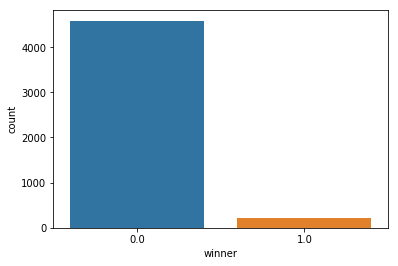

In [22]:
sns.countplot(x='winner', data = df)

- Get the number of 0 labeled data, and the number of 1 labeled data
- We can see the number of 0-labeled data is 4595, and the number of 1-labeled data is 209, which is much lower than the former one

In [23]:
print(len(df.loc[df['winner'] == 0])) #4594
print(len(df.loc[df['winner'] == 1])) #209

4586
209


Let's balance the data by sampling a small subset with replacement from the large data set.

In [24]:
#balance the data
df_subset_0 = df.loc[df['winner'] == 0]
df_subset_1 = df.loc[df['winner'] == 1]

df_subset_0.drop('winner',axis=1,inplace=True)
df_subset_1.drop('winner',axis=1,inplace=True)

#sample with replacement
df_subset_0 = df_subset_0.sample(400) 
df_subset = pd.concat([df_subset_0,df_subset_1],ignore_index = True)
df_new = df_subset.merge(df_picture_awards, left_on = 'movie_title', right_on = 'movie_title', how = 'left')
df_new = df_new.fillna(0)

In [25]:
print(len(df_new))

609


The total length of the dataset now is 609.

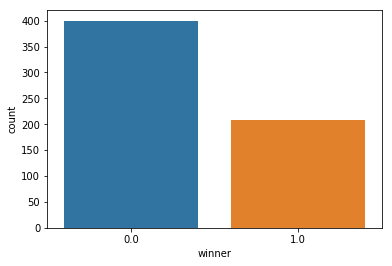

In [26]:
sns.countplot(x='winner', data = df_new)

The histogram shows that the dataset is more balanced now.

### Check The Null Value

In [27]:
#check number of null values in the dataset
df_new.isnull().sum()

movie_title             0
cast                    0
crew                    0
budget                  0
genres                  0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
year                    0
ceremony                0
award                   0
winner                  0
movieName               0
filmInfo                0
dtype: int64

Luckily, we don't have null value in this dataset. So we are ready to move to the next stage.

If you are interested in how to deal with missing value, here's a very good tutorial that you can refer to.(https://machinelearningmastery.com/handle-missing-data-python/)

## Exploratory Data Aalysis

We can do some basic EDA here to get a general sense of the data. For example, we can look at the correlation between different numeric columns, or we can draw stacked bar chart to see which genre has a higher number of nominations. Also we can draw the density curve of a variable or multi variables. Except for the following EDA, you can also explore more by yourself.
In this section, we will do the following things:
- check the data types (dyptes) of the columns in dataframe
- conduct correlation analysis on numeric data
- draw density curve
- draw stacked bar chart 

In [28]:
# check the data types and select numeric variables
df_new.dtypes

movie_title                     object
cast                            object
crew                            object
budget                           int64
genres                          object
keywords                        object
original_language               object
original_title                  object
overview                        object
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                          int64
runtime                        float64
spoken_languages                object
status                          object
tagline                         object
title                           object
vote_average                   float64
vote_count                       int64
year                            object
ceremony                       float64
award                           object
winner                         float64
movieName                

- Correlation heat map

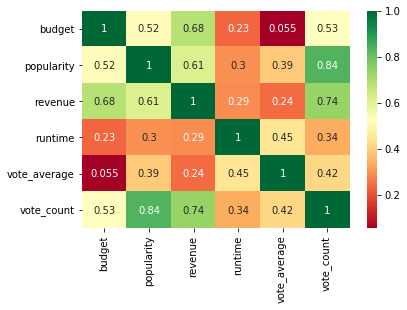

In [29]:
# correlation analysis
g = sns.heatmap(df_new[['budget','popularity','revenue','runtime','vote_average','vote_count']].corr(),cmap='RdYlGn',annot=True)

- Density Curve

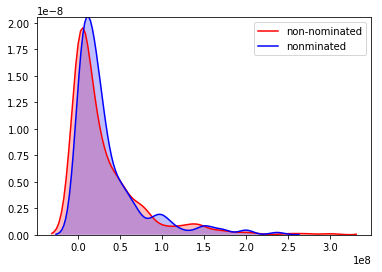

In [30]:
# budget
# density curve
budget0 = df_new[df_new['winner'] == 0]['budget']
budget1 = df_new[df_new['winner'] == 1]['budget']

g = sns.kdeplot(budget0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(budget1, legend = True, shade=True, color='b', label = 'nonminated')

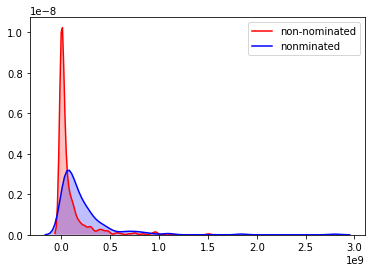

In [31]:
# revenue
# density curve
revenue0 = df_new[df_new['winner'] == 0]['revenue']
revenue1 = df_new[df_new['winner'] == 1]['revenue']

g = sns.kdeplot(revenue0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(revenue1, legend = True, shade=True, color='b', label = 'nonminated')

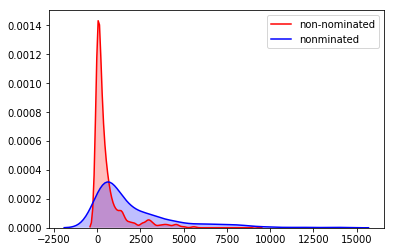

In [32]:
# vote count
vc0 = df_new[df_new['winner'] == 0]['vote_count']
vc1 = df_new[df_new['winner'] == 1]['vote_count']

g = sns.kdeplot(vc0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(vc1, legend = True, shade=True, color='b', label = 'nonminated')

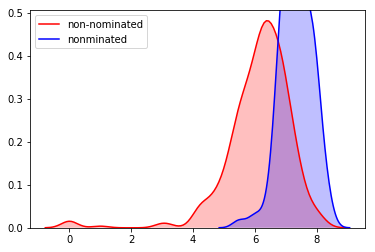

In [33]:
# vote average
va0 = df_new[df_new['winner'] == 0]['vote_average']
va1 = df_new[df_new['winner'] == 1]['vote_average']

g = sns.kdeplot(va0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(va1, legend = True, shade=True, color='b', label = 'nonminated')

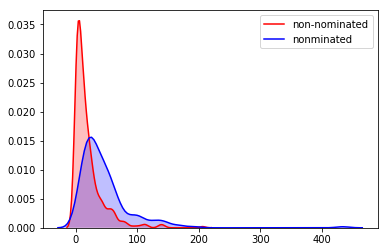

In [34]:
# popularity
popularity0 = df_new[df_new['winner'] == 0]['popularity']
popularity1 = df_new[df_new['winner'] == 1]['popularity']

g = sns.kdeplot(popularity0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(popularity1, legend = True, shade=True, color='b', label = 'nonminated')

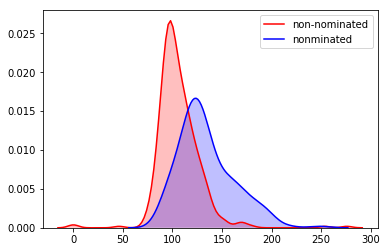

In [35]:
#runtime
runtime0 = df_new[df_new['winner'] == 0]['runtime']
runtime1 = df_new[df_new['winner'] == 1]['runtime']

g = sns.kdeplot(runtime0, legend = True, shade=True, color='r', label = 'non-nominated')
g = sns.kdeplot(runtime1, legend = True, shade=True, color='b', label = 'nonminated')

- Stacked bar char for genres

In [36]:
#genres
#clean the data
genres_name0 = {}
genres_name1 = {}
genres_set = set()
for i in range(len(df_new)):
    genres = json.loads(df_new.loc[i,'genres'])
    for it in genres:
        genres_set.add(it['name'])
        if df_new.loc[i,'winner'] == 0:
            if it['name'] not in genres_name0:
                genres_name0[it['name']] = 1
            else:
                genres_name0[it['name']] += 1
        if df_new.loc[i,'winner'] == 1:
            if it['name'] not in genres_name1:
                genres_name1[it['name']] = 1
            else:
                genres_name1[it['name']] += 1

genres_array0=[]
genres_array1=[]
for g in genres_set:
    if g in genres_name0:
        genres_array0.append(genres_name0[g])
    else:
        genres_array0.append(0)
    if g in genres_name1:
        genres_array1.append(genres_name1[g])
    else:
        genres_array1.append(0)


        
genres_all = []
genres_all.append(np.array(genres_array0)/sum(genres_array0))
genres_all.append(np.array(genres_array1)/sum(genres_array1))

In [37]:
df_genres = pd.DataFrame(genres_all, columns=list(genres_set))
print(df_genres.head())

   Adventure   History  Documentary    Comedy       War   Fantasy    Family  \
0   0.068073  0.019175     0.010547  0.145733  0.007670  0.039310  0.046021   
1   0.054326  0.072435     0.000000  0.064386  0.044266  0.028169  0.020121   

      Music   Foreign     Drama   Romance  Animation    Action   Mystery  \
0  0.022052  0.003835  0.189837  0.073826   0.023011  0.087248  0.027804   
1  0.020121  0.000000  0.364185  0.096579   0.004024  0.044266  0.020121   

     Horror   Western  TV Movie  Science Fiction  Thriller     Crime  
0  0.035475  0.003835  0.000959         0.043145  0.100671  0.051774  
1  0.004024  0.012072  0.000000         0.018109  0.078471  0.054326  


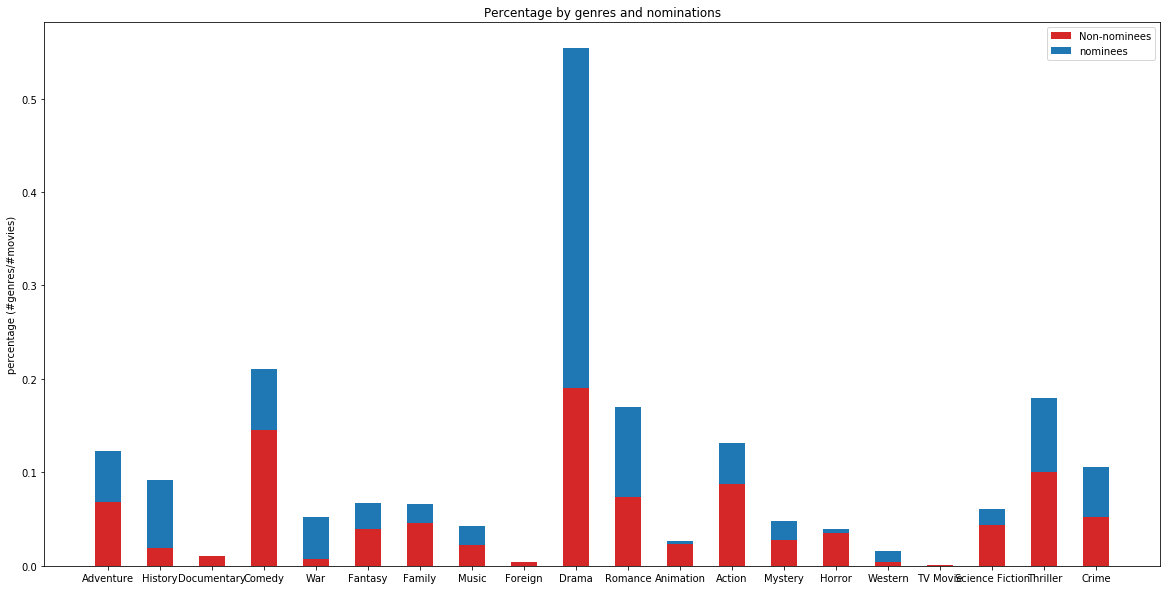

In [38]:
# draw stacked bar chart
N = len(df_genres.columns)
ind = np.arange(N)
width = 0.5

plt.figure(figsize=(20,10))
p1 = plt.bar(ind, df_genres.loc[[0]].values[0], width, color='#d62728')
p2 = plt.bar(ind, df_genres.loc[[1]].values[0], width, bottom=df_genres.loc[[0]].values[0])

plt.ylabel('percentage (#genres/#movies)')
plt.title('Percentage by genres and nominations')
plt.xticks(ind,df_genres.columns)
plt.legend((p1[0],p2[0]),('Non-nominees','nominees'))

### Conculsion
- From the correlation heat map, we can find that the popularity and vote_count, revenue and vote_count, popularity and vote_count is highly correlated.
- In order to understand the meaning of density curve, let's look at different shapes of distribution and the interpretation of each first.
![image.png](https://i.stack.imgur.com/TOsq9.png)
Some findings from the density curve:
- Nominated movies tend to have higher budget and relatively higher revenue.
- The average vote for nominated movies is much higher than the non-nominated movies.
(These findings seems obvious)
- Findings from stacked bar chart: In "Drama" and "History" genres, nominated movies have a higher percentage than non-nominated movies.


## Feature Engineering

- Since many columns such as "crew", "cast" contain information in json format, we need to extract useful information from the columns and then perform one hot encoding.
- We will transform our dataset into a all numeric matrix so that we can feed the data into our machine learning model.
- To look at the structure of column (eg."cast"), we can use: df.loc[0,'cast']


In [39]:
import json
def feature_engineering(column_name, df, json_name):
    """
    Args:
        column_name: the column name in the dataframe that contains a json file that needs to conduct feature engineering on
        df: dataframe that perform feature engineering on
        json_name: name in the json file that we want to extract
    
    Returns: new dataframe after feature engineering
    """
    
    name = {}

    for item in df[column_name]:
        group = json.loads(item)
        for it in group:
            if it[json_name] not in name:
                name[it[json_name]] = 1
            else:
                name[it[json_name]] += 1
    
    final = {}
    index = 0
    for k,v in name.items():
        if v > 1:
            final[k] = index
            index += 1
    np_item = np.zeros((len(df),len(final)))
    item_dict = {}
    row = 0
    for item in df[column_name]:
        group = json.loads(item)
        for it in group:
            if it[json_name] in final:
                index = final[it[json_name]]
                np_item[row][index] = 1
        row += 1

    df_item = pd.DataFrame(np_item, columns = list(final.keys()))
    df_output = pd.concat([df,df_item],axis = 1)
    
    return df_output


In [40]:
df2 = feature_engineering("cast", df_new, "name")
df2 = df2.drop('cast', axis = 1) #drop the column after feature engineering

In [41]:
# director
crew_name = {}

for item in df2['crew']:
    crew = json.loads(item)
    for it in crew:
        if it['job'] == 'Director':
            if it['name'] not in crew_name:
                crew_name[it['name']] = 1
            else:
                crew_name[it['name']]+=1


# set the appear tims for actors
final_crew = {}
index = 0
for k,v in crew_name.items():
    if v > 0:
        final_crew[k] = index
        index += 1
# print(len(final_crew))

np_crew = np.zeros((len(df2), len(final_crew)))
row = 0
for item in df2['crew']:
    crew = json.loads(item)
    for it in crew:
        if it['job'] == 'Director':
            if it['name'] in final_crew:
                index = final_crew[it['name']]
                np_crew[row][index] = 1
    row += 1

df_crew = pd.DataFrame(np_crew, columns = list(final_crew.keys()))
            
df3 = pd.concat([df2, df_crew], axis = 1)
# print(df.shape)

In [42]:
df3=df3.drop(['crew'],axis=1)

In [43]:
#genres
df4 = feature_engineering("genres", df3, "name")

In [44]:
df4 = df4.drop(['genres'], axis = 1)

In [45]:
#keywords
df5 = feature_engineering('keywords', df4, 'name')
df5 = df5.drop(['keywords'], axis = 1)

In [46]:
#production_companies
df6 = feature_engineering('production_companies',df5,'name')
df6 = df6.drop(['production_companies'],axis=1)

In [47]:
#production_countries
df7 = feature_engineering('production_countries',df6,'name')
df7 = df7.drop(['production_countries'],axis=1)

In [48]:
#spoken_languages
df8 = feature_engineering('spoken_languages',df7,'iso_639_1')
df8 = df8.drop(['spoken_languages'],axis=1)

Drop the columns that will not be used in the training.

In [49]:
df_clean = df8.drop(["movie_title","original_title","overview","tagline",'title','original_language','status','release_date','movieName','filmInfo','award'],axis=1)

In [50]:
df_clean.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,year,ceremony,winner,Meryl Streep,...,tr,pt,yi,af,pl,cs,sv,la,ga,fa
0,52000000,30.780599,609841637,108.0,6.4,1386,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,9.572705,15,140.0,7.4,133,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12500000,11.828068,49002684,100.0,6.0,210,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30000000,27.230493,152427960,131.0,6.0,506,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4.805651,0,97.0,6.7,99,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Training
- Split the data into training set and testing set. A useful tutorial [here](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60) for reference. 
- Since we have 3761 features in total, and only 609 rows, we will do PCA
- Use logistic regression to build the classifier

In the following code, use **train_test_split()** method in skitlearn

In [51]:
# split
X = df_clean[df_clean.columns.difference(['winner'])]
# X = StandardScaler().fit_transform(X)
y = df_clean['winner']
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7.0, random_state=0)

Since PCA will be affected by scale, we will need to scale the data before doing PCA. We can transfrom the data to unit scale (0 mean, 1 variance). **StandardScaler()** method in skitlearn can help to standardize the value. 
Notice we will **fit** on the **training set only** then apply **transfrom** to both the **training** set and the **test** set.

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In the following code, we choose 0.95 as the parameters in PCA(), which means 0.95 variance in the features will be retained.

In [53]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
fit = pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# pca = PCA(n_components = 3)
# fit = pca.fit_transform(X)
# fit2 = pca.fit(X)
# print("Explained Variance: %s" % pca.explained_variance_ratio_) 
# print(fit)


Use the Logistic Regression methond in skitlearn. Check the [document](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for details.

In [54]:
from sklearn.linear_model import LogisticRegression

- Step I: Create a logistic regression model, pass the appropriate algorithm into the solver.

In [55]:
# all parameters not specified are set to their defaults
# For small datasets, ‘liblinear’ is a good choice
logisticRegr = LogisticRegression(solver = 'liblinear')

- Step II: Train the model on the data

In [56]:
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

- Step III: Predict the result on test set.

In [57]:
# Predict for One Observation (image)
predicted = logisticRegr.predict(X_test)
print(logisticRegr.predict(X_test))
print(y_test.index)
# df8['movie_title'][y_test.index]

[ 0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.
  1.  1.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  1.  1.  0.
  1.  0.  0.  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  0.  1.]
Int64Index([576,  52, 531, 345,  55,  62, 348, 304, 206, 408, 306, 492, 181,
            357, 418, 433, 443, 590, 467, 548,  48, 233, 242, 482, 187, 505,
            205, 172, 210, 311, 346, 369, 395, 222, 103, 432, 463, 530, 435,
            319, 245, 194,  14, 338, 607, 484, 587, 358,   1, 439, 339, 390,
            552, 127, 412, 190, 372, 361,   8, 193, 122, 279, 400,  17, 424,
             21, 250,  85, 455, 178, 440, 303, 602, 246,  37, 225, 378,  34,
            564,  64, 497, 391, 567, 318, 170, 491, 597],
           dtype='int64')


- Step IV: Performance evaluation

Print the accuracy of the logistic regression. 

In [58]:
logisticRegr.score(X_test, y_test)

0.85057471264367812

Accuracy might not be the best metrics for evaluation. We can calculate other metrics such as sensitivity (recall) based on the [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [59]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
sensitivity = tp/(tp+fn)
print(sensitivity)

0.78125


The accuracy and the sensitivity of the logistic regression are almost the same, which are aroung 0.75.

### Improvement: Cross Validation
[cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-with-stratification-based-on-class-labels)
In the above modeling process, we didn't use cross validation. In order to make better estimator performance evaluation, we can use cross validation method in skitlearn


In [60]:
# 3-fold Cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
sumAccuracy = []
for train,test in skf.split(X,y):
#     logisticRegr.fit(df_clean.iloc[train][], )
    df_train = df_clean.iloc[train]
    df_test = df_clean.iloc[test]
    train_X = df_train[df_clean.columns.difference(['winner'])]
    train_y = df_train['winner']
    test_X = df_test[df_clean.columns.difference(['winner'])]
    test_y = df_test['winner']
    logisticRegr.fit(train_X, train_y)
    sumAccuracy.append(logisticRegr.score(test_X, test_y))
avg = np.mean(sumAccuracy)
print(avg)
#     print(df_clean.iloc[train,df_clean.columns.difference(['winner'])])

0.806396975542


The average accuracy calculated from the cross validation is 73.58%, which is slightly lower than the accuracy we calculated withouth cross-validation.

## Further Reading
FYI, except for logistic regression, this tutorial will list some other classification models that are widely used in Kaggle:
- [H2O Distributed Random Forest](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html)
- [xgboost tree](https://github.com/dmlc/xgboost)

If you are interested in which movie will be next year's Oscar Best Picture nominees, you can go to [TMDB](https://www.themoviedb.org/documentation/api) and scrap the movie information.